In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys, warnings, pytz
from datetime import datetime
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import norm, dirichlet, invgamma, truncnorm, skewnorm, boxcox, gamma, bernoulli, gennorm, beta
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
import scipy.special as sc
import math
import pickle

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/drive')

#read in the field dims
field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/field_dims.csv')

#also read in the batter bip distribution estimates
batter_post = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/final_dists.csv')

#also read in the 2023 positioning recs
pos_recs = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/positioning_optimization/recs_2023.csv')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']

### Bip Sampling

In [5]:
#we're going to be using Santana
batter = 467793
bhand = 0
batter_info = batter_post.loc[batter_post.batter_id_hand == str(batter) + '-' + str(bhand)]

In [6]:
#draw samples
#draw 10000 and then we'll remove homers and then just take 5000, we want to end up with the same number for both bips and bunts, which I've decided will be 5000
N = 20000
#draw horizontal angles first
choice = np.random.binomial(1, batter_info.batter_w1.values, size = N)
hd_samp = choice * beta(a = batter_info.batter_alpha1.values[0], b = batter_info.batter_beta1.values[0]).rvs(N, random_state = 42) + (1-choice) * beta(a = batter_info.batter_alpha2.values[0], b = batter_info.batter_beta2.values[0]).rvs(N, random_state = 42)
#hd_samp is between 0 and 1, so shift and scale to get it back in terms of hit directions.
hd_samp = hd_samp * 110 -55

#now we need to define is_pull, is_oppo, and is_mid so that we can sample from the appropriate launch angle dist
is_pull = (hd_samp <= 0).astype(int)
is_oppo = (hd_samp > 0).astype(int)

#sample launch angles
la_samp = is_pull * norm(loc = batter_info.batter_mean_pull.values[0], scale = batter_info.batter_sigma_pull.values[0]).rvs(size = N, random_state = 42) + is_oppo * norm(loc = batter_info.batter_mean_oppo.values[0], scale = batter_info.batter_sigma_oppo.values[0]).rvs(size = N, random_state = 42)

#define the launch angle type
is_gb = (la_samp <= 10).astype(int)
is_ld = ((la_samp > 10).astype(int) + (la_samp <= 25).astype(int) == 2).astype(int)
is_pu = (la_samp > 50).astype(int)
is_fb = 1 - is_gb - is_ld - is_pu

#sample exit speeds
ev_samp = is_gb * gamma(a = batter_info.batter_a_gb.values[0], scale = batter_info.batter_s_gb.values[0]).rvs(size = N, random_state = 42) + is_fb * gamma(a = batter_info.batter_a_fb.values[0], scale = batter_info.batter_s_fb.values[0]).rvs(size = N, random_state = 42) + is_ld * gamma(a = batter_info.batter_a_ld.values[0], scale = batter_info.batter_s_ld.values[0]).rvs(size = N, random_state = 42) + is_pu * gamma(a = batter_info.batter_a_pu.values[0], scale = batter_info.batter_s_pu.values[0]).rvs(size = N, random_state = 42)

samples = pd.DataFrame({'batter_id': [batter for _ in range(N)], 'bat_handR': [bhand for _ in range(N)], 'is_pull': is_pull, 'is_oppo': is_oppo,
                    'is_gb': is_gb, 'is_ld': is_ld, 'is_fb': is_fb, 'is_pu': is_pu, 'hit_direction': hd_samp, 'launch_angle': la_samp, 'ev2': ev_samp})

#scale hit direction by -1 for lefty hitters
samples.loc[samples.bat_handR == 0, 'hit_direction'] *= -1

In [7]:
#define the launch speed
samples['launch_speed'] = -1*(samples.ev2.values - 123)
#remove bad launch speeds
samples.loc[samples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/landing_dist_model.pkl', 'rb'))

samples['hangtime'] = model_t.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
samples['distance'] = model_dist.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
samples['landing_x'] = samples.distance.values * np.sin(np.pi * samples.hit_direction.values / 180)
samples['landing_y'] = samples.distance.values * np.cos(np.pi * samples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/xwoba_model.pkl', 'rb'))
#I used fangraphs 2023 woba weights
samples['xwoba'] = xwoba_mod.predict_proba(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

#remove balls that leave the trop
trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi
samples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(samples.hit_direction.values[i] - trop_dims.angle.values))] for i in range(samples.shape[0])]
samples= samples.loc[samples.distance < samples.wall_distance]

#remove balls that land foul
samples['landing_angle'] = np.arctan2(samples.landing_x.values, samples.landing_y.values) * 180/np.pi
samples = samples.loc[np.abs(samples.landing_angle) <= 45]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:12:18] WARNING: /workspace/src/gbm/gbtree.cc:360: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:12:18] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:12:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
<ipython-input-7-90ce3c6a655f>:22: SettingWithCopyWarning: 
A valu

In [8]:
#we only want 15000 samples, so take a random sample of 15000 of whatever is left after removing foul balls and home runs
samples = samples.sample(n=15000, replace = False)

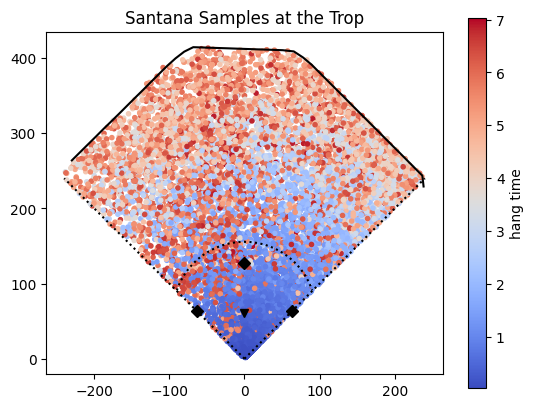

In [9]:
#plot
plt.scatter(samples.landing_x.values, samples.landing_y.values, c = samples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Santana Samples at the Trop')
plt.show()

### Bunt Samples

In [10]:
#the idea with the bunt strategy is Santana is bunting to beat the shift, so we need to estimate a distribution of LHB bunts down the third base line
raw23= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw23.csv')
raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw21= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw20= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw19= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw19.csv')
raw23 = raw23.loc[raw23['type'] == 'X']
raw22 = raw22.loc[raw22['type'] == 'X']
raw21 = raw21.loc[raw21['type'] == 'X']
raw20 = raw20.loc[raw20['type'] == 'X']
raw19 = raw19.loc[raw19['type'] == 'X']
all_data = pd.concat((raw23, raw22, raw21, raw20, raw19))
del raw19
del raw20
del raw21
del raw22
del raw23

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) <= 45]

#launch angle type
all_data['la_type'] = 0 #gb
all_data.loc[(all_data.launch_angle > 10) & (all_data.launch_angle <= 25), 'la_type'] = 1 #ld
all_data.loc[(all_data.launch_angle > 25) & (all_data.launch_angle <= 50), 'la_type'] = 2 #fb
all_data.loc[all_data.launch_angle > 50, 'la_type'] = 3 #pu
all_data['is_gb'] = 0
all_data['is_ld'] = 0
all_data['is_fb'] = 0
all_data['is_pu'] = 0
all_data.loc[all_data.la_type == 0, 'is_gb'] = 1
all_data.loc[all_data.la_type == 1, 'is_ld'] = 1
all_data.loc[all_data.la_type == 2, 'is_fb'] = 1
all_data.loc[all_data.la_type == 3, 'is_pu'] = 1

all_data['outcome'] = -1
all_data.loc[all_data.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 'sac_bunt',
                                               'sac_fly_double_play']), 'outcome'] = 0 # in play out
all_data.loc[all_data.events == 'single', 'outcome'] = 1 #single
all_data.loc[all_data.events == 'double', 'outcome'] = 2 # double
all_data.loc[all_data.events == 'triple', 'outcome'] = 3 #triple
all_data.loc[all_data.events == 'home_run', 'outcome'] = 4 #hr

#we only LHB
all_data = all_data.loc[all_data.bat_handR == 0]

<ipython-input-10-cdbf6a50f0e3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['la_type'] = 0 #gb
<ipython-input-10-cdbf6a50f0e3>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['is_gb'] = 0
<ipython-input-10-cdbf6a50f0e3>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [11]:
#we only want sacrifice bunts up the 3rd base side. Unfortunately, there is no variable defining a bunt, so we have to just look at sac bunts
all_data = all_data.loc[all_data.events == 'sac_bunt']
all_data = all_data.loc[all_data.hit_direction < -22.5]

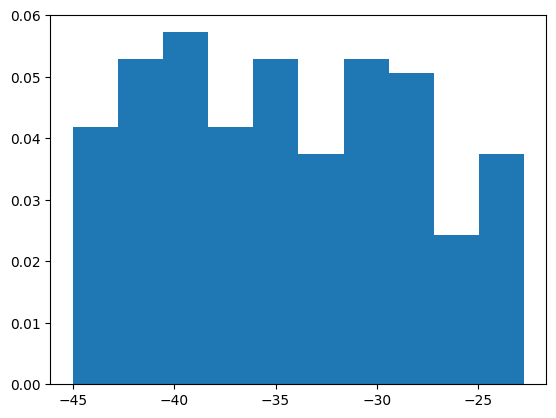

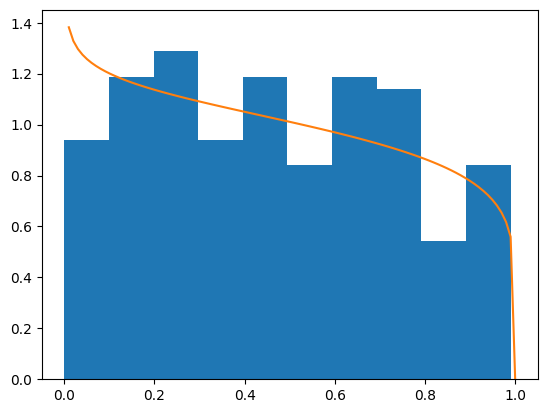

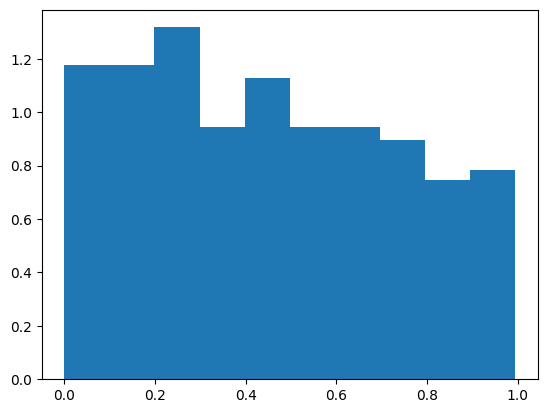

In [12]:
#estimate dist for hit direction
plt.hist(all_data.hit_direction.values, density = True, bins = 10)
plt.show()

#shift and scale so it's between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 45)/22.5
#estimate a beta distribution
a,b,loc,scale = beta.fit(all_data.hd.values, floc = 0, fscale = 1)
plt.hist(all_data.hd.values, density = True, bins = 10)
x = np.linspace(0,1,100)
plt.plot(x, beta(a=a, b=b).pdf(x), '-')
plt.show()
samps = beta(a=a,b=b).rvs(1000)
plt.hist(samps, density = True, bins = 10)
plt.show()

In [13]:
a,b

(0.9446718649441319, 1.1419137606824117)

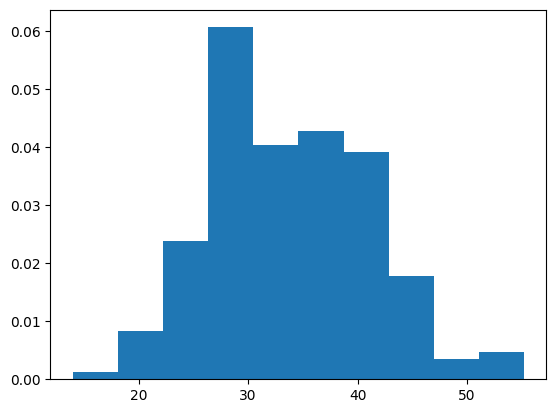

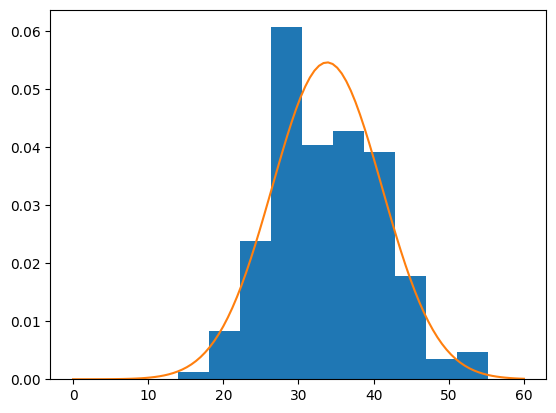

In [14]:
#now estimate dist for launch speed
plt.hist(all_data.launch_speed.values, density = True)
plt.show()
#that pretty much looks like a normal dist
x = np.linspace(0,60,100)
m = all_data.launch_speed.mean()
stdev = all_data.launch_speed.std()
plt.hist(all_data.launch_speed.values, density = True)
plt.plot(x, norm(loc = m, scale = stdev).pdf(x), '-')
plt.show()

In [15]:
m, stdev

(33.807352941176475, 7.3024049519124485)

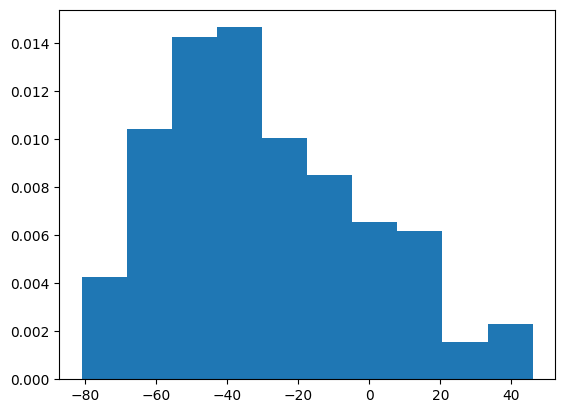

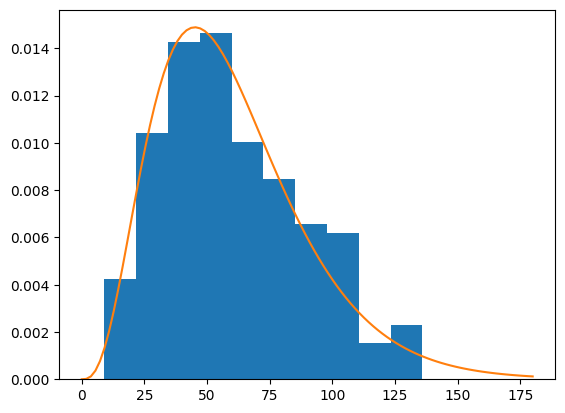

In [16]:
#finally for launch angle
plt.hist(all_data.launch_angle.values, density = True)
plt.show()
#looks like we could have a gamma dist here
all_data['la_shifted'] = all_data.launch_angle.values + 90
x = np.linspace(0,180,100)
a2,_,scale = gamma.fit(all_data.la_shifted.values, floc = 0)
plt.hist(all_data.la_shifted.values, density = True)
plt.plot(x, gamma(a=a2,scale = scale).pdf(x), '-')
plt.show()

In [17]:
a2, 1/scale

(4.00388493429465, 0.06651404939707725)

In [18]:
del all_data

In [19]:
#now we can get bunt samples
bunt_hd = beta(a,b).rvs(size = 20000, random_state = 42)
#reshift and scale
bunt_hd = bunt_hd*22.5 - 45

bunt_es = norm(loc = m, scale = stdev).rvs(size = 20000, random_state = 42)

bunt_la = gamma(a=a2, scale = scale).rvs(size = 20000, random_state = 42)
#reshift la
bunt_la = bunt_la - 90

bunt_samples = pd.DataFrame({'hit_direction': bunt_hd, 'launch_angle': bunt_la, 'launch_speed': bunt_es})
bunt_samples['batter_id'] = batter
bunt_samples['bat_handR'] = bhand

#remove weird launch angles
bunt_samples = bunt_samples.loc[bunt_samples.launch_angle < 85]
bunt_samples = bunt_samples.loc[bunt_samples.launch_angle > -85]
#weird launch speeds
bunt_samples = bunt_samples.loc[bunt_samples.launch_speed < 60]
bunt_samples = bunt_samples.loc[bunt_samples.launch_speed > 5]

#of whatever is leftover, keep just 15000 samples
bunt_samples = bunt_samples.sample(n=15000, replace = False)

In [20]:
#predict the landing spots and hang times
bunt_samples['hangtime'] = model_t.predict(bunt_samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
bunt_samples['distance'] = model_dist.predict(bunt_samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
bunt_samples['landing_x'] = bunt_samples.distance.values * np.sin(np.pi * bunt_samples.hit_direction.values / 180)
bunt_samples['landing_y'] = bunt_samples.distance.values * np.cos(np.pi * bunt_samples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
#I used fangraphs 2023 woba weights
bunt_samples['xwoba'] = xwoba_mod.predict_proba(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

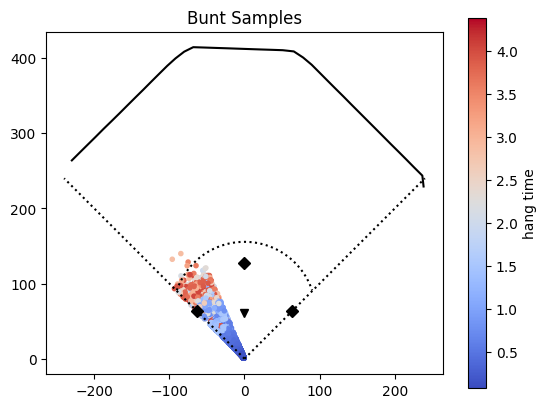

In [21]:
#plot
plt.scatter(bunt_samples.landing_x.values, bunt_samples.landing_y.values, c = bunt_samples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Bunt Samples')
plt.show()

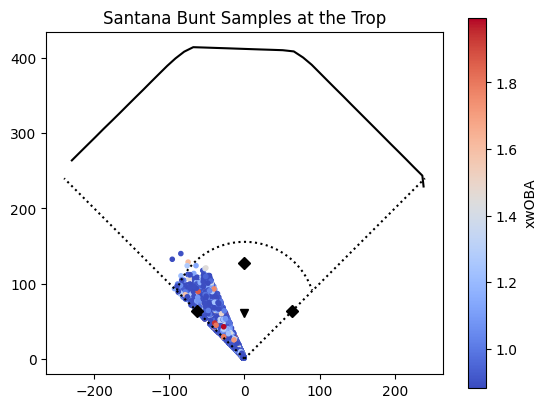

In [22]:
plt.scatter(bunt_samples.landing_x.values, bunt_samples.landing_y.values, c = bunt_samples.xwoba.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'xwOBA')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Santana Bunt Samples at the Trop')
plt.show()

In [23]:
#even though some bunts have large launch angles, we treat them all like groundballs
bunt_samples['is_gb'] = 1

In [24]:
#we only have one batter, so set the batter index to 0
bunt_samples['batter_index'] = 0
samples['batter_index'] = 0

### optimizing

In [25]:
#define the coefficients in the fly ball linear model and ground ball linear model
bunt_int =-2.7808253
bunt_angle_diff = -0.1463456
bunt_bttf = 5.86696302
bunt_bttf2 = -1.31835977

##### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

In [26]:
class DataSet(Dataset):
    def __init__(self, x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)

        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

#for the linear models, we need the landing coordinates, the hang time, the exit speed, the hit direction

features = ['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'batter_index']

train_x = samples[features].values
train_y = samples.xwoba.values
trainset = DataSet(train_x, train_y)

trainloader = DataLoader(trainset, batch_size = 1500, shuffle = True)

bunt_x = bunt_samples[features].values
bunt_y = bunt_samples.xwoba.values
buntset = DataSet(bunt_x, bunt_y)
buntloader = DataLoader(buntset, batch_size = 1500, shuffle = True)

In [27]:
#define a constraint function. Note that the embedding layer will not necessarily have the constraints applied, so we need to apply them before we make fielding recs
def constraint_func(bat_emb, constraint_type = 1):

    #first base constraint: must be within 40 feet from firstbase so he can cover the bag
    _1b = torch.tensor([[63.64, 63.64]]).to(device)
    p1b = bat_emb[:,0:2] - _1b
    _1b_dist = torch.norm(p1b, dim = 1)
    _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
    _1b_dist2 = _1b_dist.clone()
    #reset dists that are too far
    _1b_dist2[_1b_dist > 40] = 40.
    #reset coordinates by maintaining the same angle with first base but shrinking the distance
    p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
    p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

    if constraint_type == 2:
      #shift ban constraint: infielders have to be in dirt and two on either side of second base.
      #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
      #get the coordinates of the infielders relative to the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 95] = 95.
      md42[md4 > 95] = 95.
      md52[md5 > 95] = 95.
      md62[md6 > 95] = 95.

      #reset illegal angles (by the shift ban) to be legal once again we need to clone
      ma32 = ma3.clone()
      ma42 = ma4.clone()
      ma52 = ma5.clone()
      ma62 = ma6.clone()
      ma32[ma3 < 0] = 0.
      ma42[ma4 < 0] = 0.
      ma52[ma5 > 0] = 0.
      ma62[ma6 > 0] = 0.

      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma32)
      y3 = md32 * torch.cos(ma32)
      x4 = md42 * torch.sin(ma42)
      y4 = md42 * torch.cos(ma42)
      x5 = md52 * torch.sin(ma52)
      y5 = md52 * torch.cos(ma52)
      x6 = md62 * torch.sin(ma62)
      y6 = md62 * torch.cos(ma62)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    elif constraint_type == 3:
      #infielders must be within 110 feet of the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 110 to 110. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 100] = 100.
      md42[md4 > 100] = 100.
      md52[md5 > 100] = 100.
      md62[md6 > 100] = 100.


      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma3)
      y3 = md32 * torch.cos(ma3)
      x4 = md42 * torch.sin(ma4)
      y4 = md42 * torch.cos(ma4)
      x5 = md52 * torch.sin(ma5)
      y5 = md52 * torch.cos(ma5)
      x6 = md62 * torch.sin(ma6)
      y6 = md62 * torch.cos(ma6)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    else:
      #no shift ban
      bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

    return bat_emb2

class BuntOptimizer(nn.Module):
    def __init__(self, constraint_type = 1):
        super().__init__()

        self.embed = nn.Embedding(samples.batter_index.max() + 1, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((samples.batter_index.max()+1,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.embed(batter_idx)

        #first base constraint: must be within 40 feet from firstbase so he can cover the bag
        _1b = torch.tensor([[63.64, 63.64]]).to(device)
        p1b = bat_emb[:,0:2] - _1b
        _1b_dist = torch.norm(p1b, dim = 1)
        _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
        _1b_dist2 = _1b_dist.clone()
        #reset dists that are too far
        _1b_dist2[_1b_dist > 40] = 40.
        #reset coordinates by maintaining the same angle with first base but shrinking the distance
        p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
        p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

        if self.constraint_type == 2:
          #shift ban constraint: infielders have to be in dirt and two on either side of second base.
          #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
          #get the coordinates of the infielders relative to the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 95] = 95.
          md42[md4 > 95] = 95.
          md52[md5 > 95] = 95.
          md62[md6 > 95] = 95.

          #reset illegal angles (by the shift ban) to be legal once again we need to clone
          ma32 = ma3.clone()
          ma42 = ma4.clone()
          ma52 = ma5.clone()
          ma62 = ma6.clone()
          ma32[ma3 < 0] = 0.
          ma42[ma4 < 0] = 0.
          ma52[ma5 > 0] = 0.
          ma62[ma6 > 0] = 0.

          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma32)
          y3 = md32 * torch.cos(ma32)
          x4 = md42 * torch.sin(ma42)
          y4 = md42 * torch.cos(ma42)
          x5 = md52 * torch.sin(ma52)
          y5 = md52 * torch.cos(ma52)
          x6 = md62 * torch.sin(ma62)
          y6 = md62 * torch.cos(ma62)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        elif self.constraint_type == 3:
          #infielders must be within 110 feet of the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 110 to 110. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 100] = 100.
          md42[md4 > 100] = 100.
          md52[md5 > 100] = 100.
          md62[md6 > 100] = 100.


          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma3)
          y3 = md32 * torch.cos(ma3)
          x4 = md42 * torch.sin(ma4)
          y4 = md42 * torch.cos(ma4)
          x5 = md52 * torch.sin(ma5)
          y5 = md52 * torch.cos(ma5)
          x6 = md62 * torch.sin(ma6)
          y6 = md62 * torch.cos(ma6)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        else:
          #no shift ban
          bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)
        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(bunt_int + bunt_angle_diff * closest_ifer_angle.squeeze(1) + bunt_bttf * bttf + bunt_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs


In [28]:
#define my custom loss function, maximize outs, so minimize negative outs
def maximize_outs(output, target = None):
    #we just return the negative mean of outs. We want to minimze that
    return -1*torch.mean(output)

#minimize woba
def minimize_woba(output, target):
    #output would obviously be the output of the net, which is an out probability. Target is the woba of a hit, so we take 1-out prob and multiply that by target, and that gives xwoba of a non out, and we want to minimize this
    return torch.mean((1-output) * target)

### Optimize for non-bunt dist

In [29]:
#training parameters
learning_rate = 5
epochs = 2000
loss_fn = maximize_outs

opt1 = BuntOptimizer(3).to(device)
optimizer = torch.optim.SGD(opt1.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.669165
epoch : 2/2000, loss = -0.670589
epoch : 3/2000, loss = -0.672553
epoch : 4/2000, loss = -0.674509
epoch : 5/2000, loss = -0.676411
epoch : 6/2000, loss = -0.678148
epoch : 7/2000, loss = -0.679840
epoch : 8/2000, loss = -0.681392
epoch : 9/2000, loss = -0.682900
epoch : 10/2000, loss = -0.684363
epoch : 11/2000, loss = -0.685724
epoch : 12/2000, loss = -0.687069
epoch : 13/2000, loss = -0.688363
epoch : 14/2000, loss = -0.689634
epoch : 15/2000, loss = -0.690848
epoch : 16/2000, loss = -0.692012
epoch : 17/2000, loss = -0.693159
epoch : 18/2000, loss = -0.694259
epoch : 19/2000, loss = -0.694933
epoch : 20/2000, loss = -0.695370
epoch : 21/2000, loss = -0.695769
epoch : 22/2000, loss = -0.696171
epoch : 23/2000, loss = -0.696501
epoch : 24/2000, loss = -0.696887
epoch : 25/2000, loss = -0.697283
epoch : 26/2000, loss = -0.697625
epoch : 27/2000, loss = -0.697999
epoch : 28/2000, loss = -0.698362
epoch : 29/2000, loss = -0.698706
epoch : 30/2000, loss =

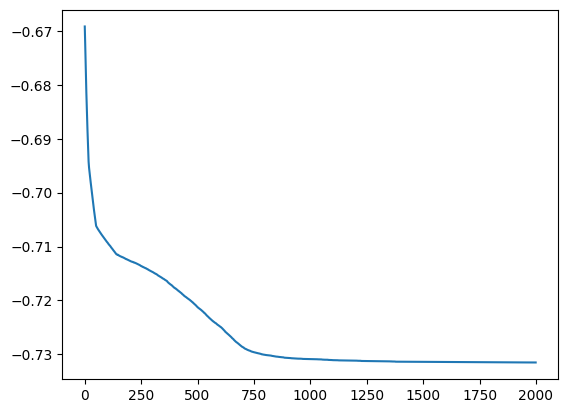

In [30]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt1(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results
bat_embeddings = opt1.embed.weight.data
constrained = constraint_func(bat_embeddings, 3)
batter_weights1 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

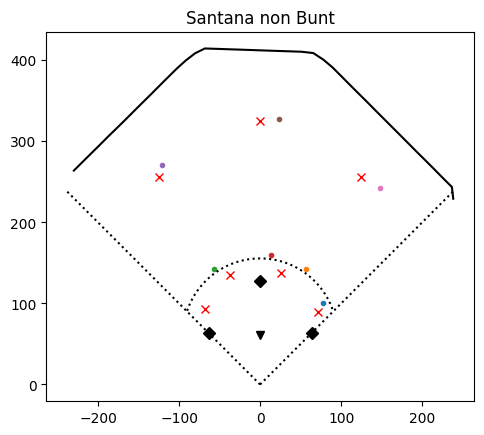

In [31]:
standard_pos = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
for i in range(7):
    plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i+3)], '.')
    plt.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'rx')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.title('Santana non Bunt')
plt.show()

In [32]:
#calculate the final loss
x = trainset[:][0].to(device)
y = trainset[:][1].to(device)
outputs = opt1(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Out prob if Santana uses non-bunt strategy against the non-bunt defense: ' + str(-1*loss_val))

Out prob if Santana uses non-bunt strategy against the non-bunt defense: 0.7315043210983276


### Optimize for Bunt Dist

In [33]:
#training parameters
learning_rate = 5
epochs = 2000
loss_fn = maximize_outs

opt2 = BuntOptimizer(3).to(device)
optimizer = torch.optim.SGD(opt2.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.881187
epoch : 2/2000, loss = -0.882488
epoch : 3/2000, loss = -0.884193
epoch : 4/2000, loss = -0.886116
epoch : 5/2000, loss = -0.887758
epoch : 6/2000, loss = -0.889217
epoch : 7/2000, loss = -0.890701
epoch : 8/2000, loss = -0.891959
epoch : 9/2000, loss = -0.893045
epoch : 10/2000, loss = -0.894098
epoch : 11/2000, loss = -0.895120
epoch : 12/2000, loss = -0.895848
epoch : 13/2000, loss = -0.896670
epoch : 14/2000, loss = -0.897472
epoch : 15/2000, loss = -0.898341
epoch : 16/2000, loss = -0.898830
epoch : 17/2000, loss = -0.899611
epoch : 18/2000, loss = -0.900425
epoch : 19/2000, loss = -0.901030
epoch : 20/2000, loss = -0.901596
epoch : 21/2000, loss = -0.902383
epoch : 22/2000, loss = -0.902811
epoch : 23/2000, loss = -0.903729
epoch : 24/2000, loss = -0.904275
epoch : 25/2000, loss = -0.905001
epoch : 26/2000, loss = -0.905729
epoch : 27/2000, loss = -0.906592
epoch : 28/2000, loss = -0.907427
epoch : 29/2000, loss = -0.908340
epoch : 30/2000, loss =

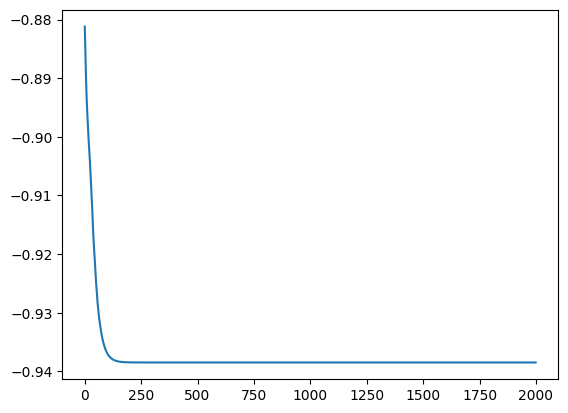

In [34]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(buntloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt2(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(buntloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results
bat_embeddings = opt2.embed.weight.data
constrained = constraint_func(bat_embeddings, 3)
batter_weights2 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights2[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

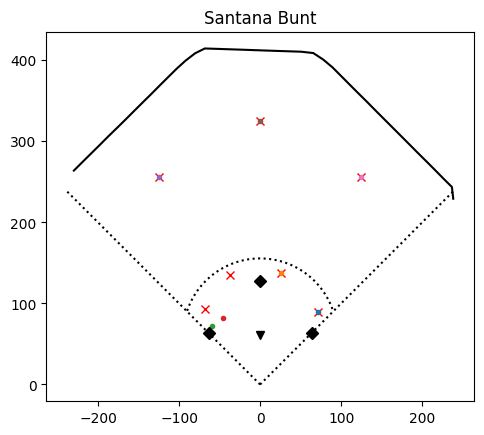

In [35]:
for i in range(7):
    plt.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'rx')
    plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], '.')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.title('Santana Bunt')
plt.show()

In [36]:
#calculate the final loss
x = buntset[:][0].to(device)
y = buntset[:][1].to(device)
outputs = opt2(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses bunt strategy against the bunt defense: ' + str(1+loss_val))
outputs = opt1(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses bunt strategy against non-bunt defense: ' + str(1+loss_val))

x = trainset[:][0].to(device)
y = trainset[:][1].to(device)
outputs = opt2(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses non-bunt strategy against bunt defense: ' + str(1+loss_val))
outputs = opt1(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses non-bunt strategy against the non-bunt defense: ' + str(1+loss_val))

Expected batting average if Santana uses bunt strategy against the bunt defense: 0.06151527166366577
Expected batting average if Santana uses bunt strategy against non-bunt defense: 0.4531111717224121
Expected batting average if Santana uses non-bunt strategy against bunt defense: 0.35377299785614014
Expected batting average if Santana uses non-bunt strategy against the non-bunt defense: 0.26849567890167236


### Equilibrium: Assume Santana either bunts or doesn't bunt depending on what has a higher expected batting average against the positioning strategy

In [88]:
#training parameters
learning_rate = 5
epochs = 2000
loss_fn = maximize_outs

opt3 = BuntOptimizer(3).to(device)
optimizer = torch.optim.SGD(opt3.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.669170
epoch : 2/2000, loss = -0.670600
epoch : 3/2000, loss = -0.672538
epoch : 4/2000, loss = -0.674510
epoch : 5/2000, loss = -0.676380
epoch : 6/2000, loss = -0.678153
epoch : 7/2000, loss = -0.679827
epoch : 8/2000, loss = -0.681416
epoch : 9/2000, loss = -0.682862
epoch : 10/2000, loss = -0.684366
epoch : 11/2000, loss = -0.685712
epoch : 12/2000, loss = -0.687067
epoch : 13/2000, loss = -0.688360
epoch : 14/2000, loss = -0.689639
epoch : 15/2000, loss = -0.690847
epoch : 16/2000, loss = -0.691988
epoch : 17/2000, loss = -0.693149
epoch : 18/2000, loss = -0.694259
epoch : 19/2000, loss = -0.694922
epoch : 20/2000, loss = -0.695362
epoch : 21/2000, loss = -0.695770
epoch : 22/2000, loss = -0.696160
epoch : 23/2000, loss = -0.696515
epoch : 24/2000, loss = -0.696888
epoch : 25/2000, loss = -0.697262
epoch : 26/2000, loss = -0.697623
epoch : 27/2000, loss = -0.698010
epoch : 28/2000, loss = -0.698357
epoch : 29/2000, loss = -0.698717
epoch : 30/2000, loss =

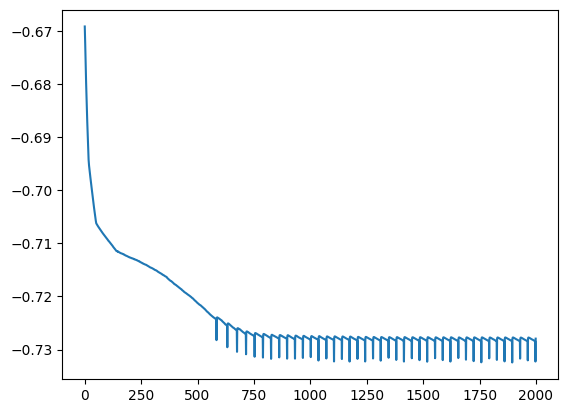

In [89]:
for i in range(epochs):
    #figure out whether Gallo will bunt or not bunt against the current defense
    x = trainset[:][0].to(device)
    y = trainset[:][1].to(device)
    outputs = opt3(x)
    loss = loss_fn(outputs, y)
    non_bunt_loss = loss.item()
    x = buntset[:][0].to(device)
    y = buntset[:][1].to(device)
    outputs = opt3(x)
    loss = loss_fn(outputs, y)
    bunt_loss = loss.item()

    if bunt_loss > non_bunt_loss:
        #gallo is going to bunt
        #loop through batches of training data
        loss_val = 0
        for batch, (x, y) in enumerate(buntloader):
            x = x.to(device)
            y = y.to(device)
            #zero out gradients
            optimizer.zero_grad()
            #run the model
            outputs = opt3(x)
            #calculate loss
            loss = loss_fn(outputs, y)
            loss_val += loss.item()
            #backprop
            loss.backward()
            optimizer.step()


        train_losses.append(loss_val / len(buntloader))

        print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

    else:
        #gallo is not going to bunt
        #loop through batches of training data
        loss_val = 0
        for batch, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)
            #zero out gradients
            optimizer.zero_grad()
            #run the model
            outputs = opt3(x)
            #calculate loss
            loss = loss_fn(outputs, y)
            loss_val += loss.item()
            #backprop
            loss.backward()
            optimizer.step()


        train_losses.append(loss_val / len(trainloader))

        print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results. Note both opt3 and bopt3 should now have the same embeddings, so you can use either one here
bat_embeddings = opt3.embed.weight.data
#I currently have two different constraint functions, but the bunt constraint should be usable in the non-bunt constraint, so TODO: combine bunt constraint and non-bunt constraint into 1
constrained = constraint_func(bat_embeddings, 3)
batter_weights3 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights3[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

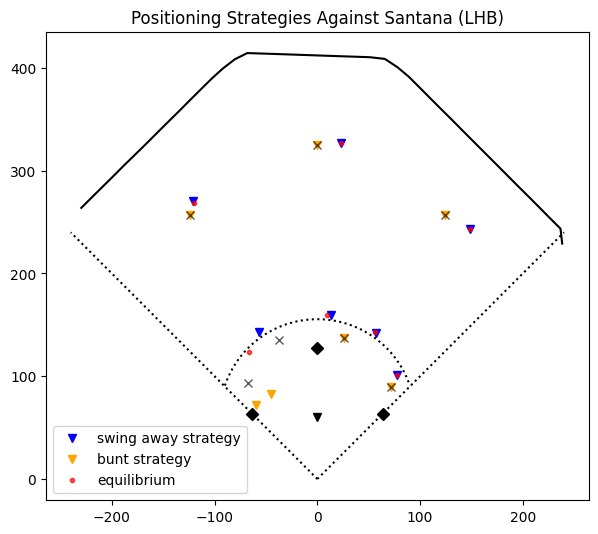

In [98]:
plt.figure(figsize=((7,7)))
for i in range(7):
    if i == 6:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv', label = 'swing away strategy')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange', label = 'bunt strategy')
      plt.plot(batter_weights3['x' + str(i + 3)], batter_weights3['y' + str(i+3)], 'r.', label = 'equilibrium', alpha = 0.7)
    else:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange')
      plt.plot(batter_weights3['x' + str(i + 3)], batter_weights3['y' + str(i+3)], 'r.', alpha = 0.7)
    plt.plot(standard_pos[2*i], standard_pos[2*i+1], 'kx', alpha = 0.65)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Positioning Strategies Against Santana (LHB)')
plt.show()

In the equilibrium strategy, you can see the defense pretty much plays in the same positioning across the board as they do in the non-bunt defensive strategy, except the third baseman moves in to a much shorter depth.

In [92]:
#calculate the final loss
x = buntset[:][0].to(device)
y = buntset[:][1].to(device)
outputs = opt3(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses bunt strategy against the equilibrium defense: ' + str(1+loss_val))

x = trainset[:][0].to(device)
y = trainset[:][1].to(device)
outputs = opt3(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if Santana uses non-bunt strategy against the equilibrium defense: ' + str(1+loss_val))

Expected batting average if Santana uses bunt strategy against the equilibrium defense: 0.2483847737312317
Expected batting average if Santana uses non-bunt strategy against the equilibrium defense: 0.2721741795539856


In the equilibrium, Santana should bunt. That gives him an expected batting average of 0.236 rather than 0.235 if he swings away. Note that this is an improvement over the batting average if he swings away against the non-bunt defense, which is what he almost always tends to do and which gives an expected batting average of 0.231. Thus, by being willing to bunt when that is advantageous, Santana forces the defense to position that helps him get more hits. Notably, whether he bunts or chooses the suboptimal swing away strategy, he still has a better batting average than when he swings away against the regular shift. Thus, by being willing to bunt when that is the optimal strategy, Santana improves his expected batting average in the equilibrium whether he swings away or bunts.